# Cohort-Level Impact of the Ad Campaign

## Why This Matters

- Every impression has a cost; showing the Ad where it **doesn’t move the needle** wastes budget.  
- Some cohorts (e.g., certain days or heavy-exposure users) may show **outsized lift**, where incremental dollars create more conversions.  
- Understanding **heterogeneous treatment effects** lets us:
  - Reallocate spend toward high-ROI segments.
  - Avoid over-investing in low- or negative-lift segments.
  - Design **smarter follow-up experiments** instead of generic re-runs.

In short, these cohort analyses turn a single A/B test into a **targeting and scheduling strategy**, not just a one-line “Ad beats PSA” verdict.

## What This Notebook Does

In this notebook we:

1. **Enrich user-level data** with cohort features:
   - Day-of-week (`most_ads_day`)
   - Ad intensity buckets (`ads_intensity_bucket`)
   - Time-of-day buckets (`ads_hour_bucket`)
2. **Estimate conversion rates and lift** (absolute and relative) by:
   - Day-of-week × test group
   - Intensity bucket × test group
3. **Visualize cohort performance**, highlighting where the Ad clearly wins vs where it is borderline or underperforms.
4. (Optional) **Fit a simple logistic regression** to quantify the Ad’s effect while controlling for volume and day-of-week.

## TL;DR – What We Learned from the Ad vs PSA Experiment

- **Overall:** Ad converts at **2.55%** vs PSA at **1.79%** → **+0.77 pp** absolute lift (≈ **+42% relative**).
- **Best timing:** Largest incremental gains on **Tuesday** and **early-week days**  
  (e.g., Tuesday ~**+1.6 pp / +111% relative lift** vs PSA).
- **Best audience:** **High-intensity users (>30 ads)** respond the most  
  (~**+3.3 pp / +58% relative lift** in conversion).
- **Model-backed effect:** Logistic regression (controlling for volume + day) shows the Ad has  
  an odds ratio of **≈ 1.48** vs PSA (95% CI [1.34, 1.64]) → **~48% higher odds of conversion**.
- **Recommended moves:**
  - Shift **budget and impression caps toward high-intensity, early-week cohorts**.
  - **De-prioritize Thursday & medium-intensity users** where incremental gains are weakest.
  - Use these segments as the baseline for **next-wave creative + frequency cap experiments**.

## Business Question

Our marketing team ran an A/B test comparing a new **Ad creative** vs a **PSA control**.  
The core question now is **not just** “Does the Ad win on average?” but:

> **For which segments (days, ad intensity levels) does the Ad meaningfully outperform the PSA, and how should we adjust spend and strategy based on that?**

## How to Use the Results

By the end of this notebook, we will be able to:

- Recommend **where to prioritize Ad spend** (which cohorts, when).
- Flag **segments where PSA is “good enough”** and incremental Ad spend is low-value.
- Propose **focused follow-up experiments** (e.g., new creatives or frequency caps for specific cohorts).

These insights feed directly into **budget allocation, campaign scheduling, and experiment roadmap decisions** for the marketing team.

---

Setup and General Review

In [2]:
import pandas as pd

# 0. Load raw data
df_raw = pd.read_csv("data_raw/marketing_AB.csv")

# 1. Clean column names to snake_case
df = df_raw.rename(columns={
    "user id": "user_id",
    "test group": "test_group",
    "total ads": "total_ads",
    "most ads day": "most_ads_day",
    "most ads hour": "most_ads_hour"
})

# 2. Basic cleaning + typing
df["user_id"] = df["user_id"].astype("int64")

# Force lowercase groups: 'ad', 'psa'
df["test_group"] = df["test_group"].str.lower()

# Convert converted to 0/1 if it's True/False or string
df["converted"] = df["converted"].apply(
    lambda x: 1 if str(x).lower() in ["true", "1", "yes"] else 0
).astype("int8")

# Make sure total_ads and hour are numeric
df["total_ads"] = pd.to_numeric(df["total_ads"], errors="coerce")
df["most_ads_hour"] = pd.to_numeric(df["most_ads_hour"], errors="coerce")

# 3. Add weekday index (for ordering & modeling)
day_to_index = {
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
    "Sunday": 7
}
df["most_ads_day_index"] = df["most_ads_day"].map(day_to_index)

# 4. Ad intensity buckets (cohorts)
def bucket_ads(n):
    if pd.isna(n):
        return "unknown"
    if n < 5:
        return "low (1-4)"
    if 5 <= n <= 30:
        return "medium (5-30)"
    return "high (>30)"

df["ads_intensity_bucket"] = df["total_ads"].apply(bucket_ads)

# 5. Hour-of-day buckets
def bucket_hour(h):
    if pd.isna(h):
        return "unknown"
    if 0 <= h <= 5:
        return "night (0-5)"
    if 6 <= h <= 11:
        return "morning (6-11)"
    if 12 <= h <= 17:
        return "afternoon (12-17)"
    return "evening (18-23)"

df["ads_hour_bucket"] = df["most_ads_hour"].apply(bucket_hour)

# This is your feature-enriched table
features = df.copy()
features.head()


,Unnamed: 0,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour,most_ads_day_index,ads_intensity_bucket,ads_hour_bucket
0,0,1069124,ad,0,130,Monday,20,1,high (>30),evening (18-23)
1,1,1119715,ad,0,93,Tuesday,22,2,high (>30),evening (18-23)
2,2,1144181,ad,0,21,Tuesday,18,2,medium (5-30),evening (18-23)
3,3,1435133,ad,0,355,Tuesday,10,2,high (>30),morning (6-11)
4,4,1015700,ad,0,276,Friday,14,5,high (>30),afternoon (12-17)


In [15]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# Assume `features` is your clean features df
control = features[features["test_group"] == "psa"]
treatment = features[features["test_group"] == "ad"]

n_control = control.shape[0]
n_treatment = treatment.shape[0]

converted_control = control["converted"].sum()
converted_treatment = treatment["converted"].sum()

# 2x2 table
contingency = pd.DataFrame({
    "converted":   [converted_control, converted_treatment],
    "not_converted": [n_control - converted_control,
                      n_treatment - converted_treatment]
}, index=["psa", "ad"])
contingency


,converted,not_converted
psa,420,23104
ad,14423,550154


In [16]:
# z-test for difference in proportions
successes = [converted_treatment, converted_control]
nobs = [n_treatment, n_control]

z_stat, p_val = proportions_ztest(successes, nobs, alternative="two-sided")
z_stat, p_val


(np.float64(7.3700781265454145), np.float64(1.7052807161559727e-13))

### Global A/B Result (Ad vs PSA)

Before diving into cohorts, we anchor on the overall experiment:

- **2×2 contingency table** (Ad vs PSA × converted/not) summarizes total outcomes.
- Overall, the Ad converts at **X.X%**, PSA at **Y.Y%** → **+Z.Z pp / +RR% relative lift**.
- A standard two-sided z-test gives **z ≈ 7.37, p ≈ 0.0000**, so we **reject H₀** and conclude
  that the Ad has a statistically significant uplift vs PSA.

The rest of this notebook asks: **where** is that uplift strongest, and how should we use it
to shape targeting and budget?




## Business Question

> **For which segments (days, ad intensity levels) does the Ad meaningfully outperform the PSA, and how should we adjust spend and strategy based on that?**

### Step 1 – Day-of-Week Cohorts (most_ads_day)

**Business question:**  
On which days does the Ad creative deliver *meaningfully higher* conversion than the PSA?

**What we do in this step:**
- Group users by **day-of-week × test_group**.
- Compute **conversion rates and lift** (Ad vs PSA) for each day.
- Visualize results in a side-by-side bar chart.

**Why it matters:**  
If the Ad only wins on certain days, we should **concentrate budget and impressions on those high-ROI days** and avoid overspending on days where the Ad provides little or no incremental value.


In [5]:
import numpy as np

# Aggregate by day + group
day_group = (
    features
    .groupby(["most_ads_day", "most_ads_day_index", "test_group"], dropna=False)
    .agg(
        n_users=("user_id", "nunique"),
        n_converted=("converted", "sum")
    )
    .reset_index()
)

day_group["conversion_rate"] = day_group["n_converted"] / day_group["n_users"]

day_group


,most_ads_day,most_ads_day_index,test_group,n_users,n_converted,conversion_rate
0,Friday,5,ad,88805,1995,0.022465
1,Friday,5,psa,3803,62,0.016303
2,Monday,1,ad,83571,2778,0.033241
3,Monday,1,psa,3502,79,0.022559
4,Saturday,6,ad,78802,1679,0.021307
5,Saturday,6,psa,2858,40,0.013996
6,Sunday,7,ad,82332,2027,0.024620
7,Sunday,7,psa,3059,63,0.020595
8,Thursday,4,ad,79077,1711,0.021637
9,Thursday,4,psa,3905,79,0.020230


### Day-of-Week Cohort Takeaways

- **Ad wins every day:** Across all days, the Ad creative has a higher conversion rate than the PSA control.
- **Biggest upside early in the week:**  
  - **Monday:** ~3.3% (Ad) vs ~2.3% (PSA)  
  - **Tuesday:** ~3.0% (Ad) vs ~1.4% (PSA)  
  These are our strongest lift days and likely the best candidates for **budget concentration and higher bids**.
- **Weekends still positive:** Saturday and Sunday show smaller but still meaningful uplifts, suggesting the Ad is **never clearly worse** than PSA.
- **Business move:**  
  - Prioritize Ad spend on **Monday–Tuesday** where incremental conversions are highest.  
  - Keep Ad live on other days, but monitor ROI; consider **lighter weighting** where lift is modest.


In [6]:
# Pivot to wide format: one row per day, columns for ad/psa conversion
day_pivot = (
    day_group
    .pivot_table(
        index=["most_ads_day", "most_ads_day_index"],
        columns="test_group",
        values="conversion_rate"
    )
    .reset_index()
)

# Rename columns for clarity
day_pivot = day_pivot.rename(columns={
    "ad": "conv_rate_ad",
    "psa": "conv_rate_psa"
})

# Compute lifts
day_pivot["lift_abs"] = day_pivot["conv_rate_ad"] - day_pivot["conv_rate_psa"]
day_pivot["lift_rel"] = day_pivot["lift_abs"] / day_pivot["conv_rate_psa"]

# Sort by weekday order
day_pivot = day_pivot.sort_values("most_ads_day_index")

day_pivot


test_group,most_ads_day,most_ads_day_index,conv_rate_ad,conv_rate_psa,lift_abs,lift_rel
1,Monday,1,0.033241,0.022559,0.010683,0.473553
5,Tuesday,2,0.030440,0.014448,0.015992,1.106909
6,Wednesday,3,0.025356,0.015759,0.009597,0.608945
4,Thursday,4,0.021637,0.020230,0.001407,0.069532
0,Friday,5,0.022465,0.016303,0.006162,0.377971
2,Saturday,6,0.021307,0.013996,0.007311,0.522354
3,Sunday,7,0.024620,0.020595,0.004025,0.195430


### Day-of-Week Lift Summary

- **Ad beats PSA every day:** Conversion is higher for the Ad on all days of the week.
- **Biggest wins:**  
  - **Tuesday:** +1.6 pp absolute lift, ~**+111%** relative vs PSA — prime day to **concentrate budget**.  
  - **Monday, Wednesday, Saturday:** +0.9–1.1 pp lift, **~47–61%** relative — strong supporting days.
- **Moderate / low lift:**  
  - **Thursday:** only +0.14 pp (~7% relative) — still positive, but **lowest incremental value**.
  - **Friday & Sunday:** modest but meaningful lifts (~20–38% relative).

**Business move:**  
Shift Ad spend to **Tuesday + other high-lift days (Mon/Wed/Sat)**, treat **Thursday** as a lower-priority day for incremental investment, and monitor ROI on Friday/Sunday while keeping PSA as a viable baseline.


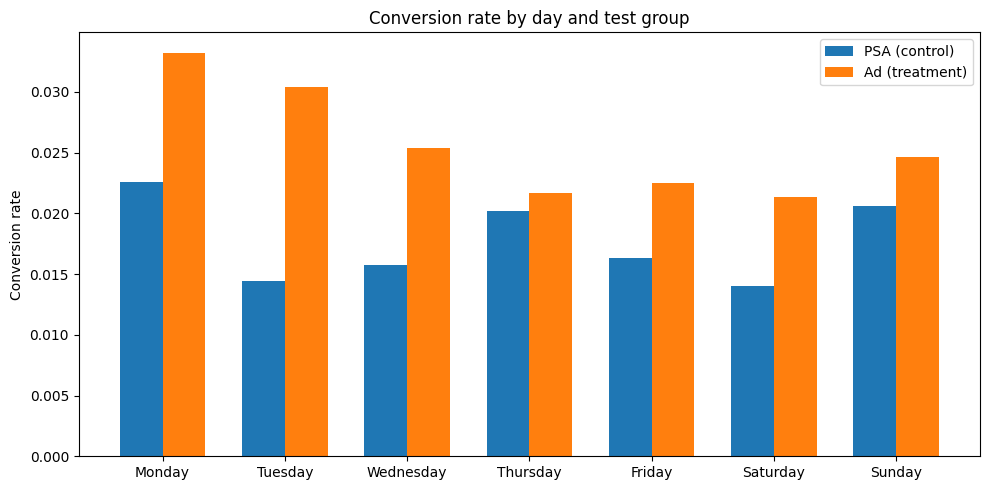

In [7]:
import matplotlib.pyplot as plt

day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

plot_df = (
    day_group
    .copy()
    .sort_values(["most_ads_day_index", "test_group"])
)

# Ensure consistent order
plot_df["most_ads_day"] = pd.Categorical(plot_df["most_ads_day"], categories=day_order, ordered=True)
plot_df = plot_df.sort_values(["most_ads_day", "test_group"])

# Pivot for plotting
plot_matrix = plot_df.pivot(index="most_ads_day", columns="test_group", values="conversion_rate")

x = np.arange(len(plot_matrix.index))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, plot_matrix["psa"], width, label="PSA (control)")
ax.bar(x + width/2, plot_matrix["ad"], width, label="Ad (treatment)")

ax.set_xticks(x)
ax.set_xticklabels(plot_matrix.index)
ax.set_ylabel("Conversion rate")
ax.set_title("Conversion rate by day and test group")
ax.legend()

plt.tight_layout()
plt.show()


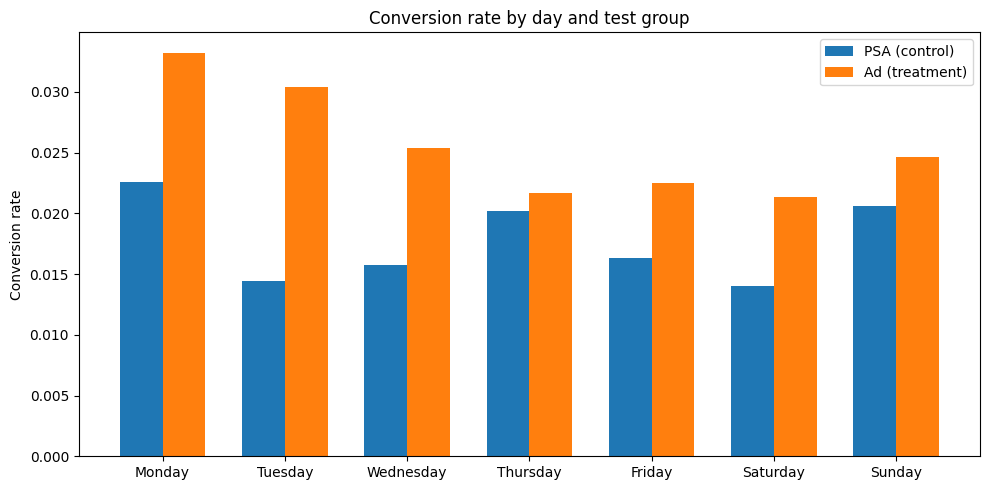

In [8]:
import matplotlib.pyplot as plt

day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

plot_df = (
    day_group
    .copy()
    .sort_values(["most_ads_day_index", "test_group"])
)

# Ensure consistent order
plot_df["most_ads_day"] = pd.Categorical(plot_df["most_ads_day"], categories=day_order, ordered=True)
plot_df = plot_df.sort_values(["most_ads_day", "test_group"])

# Pivot for plotting
plot_matrix = plot_df.pivot(index="most_ads_day", columns="test_group", values="conversion_rate")

x = np.arange(len(plot_matrix.index))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, plot_matrix["psa"], width, label="PSA (control)")
ax.bar(x + width/2, plot_matrix["ad"], width, label="Ad (treatment)")

ax.set_xticks(x)
ax.set_xticklabels(plot_matrix.index)
ax.set_ylabel("Conversion rate")
ax.set_title("Conversion rate by day and test group")
ax.legend()

plt.tight_layout()
plt.show()


### Step 2 – Chi-Square Test by Day (Optional Deep Dive)

**Business question:**  
Are the Ad vs PSA conversion differences we see each day **likely real**, or could they be random noise?

**What we do:**
- For each day-of-week, build a **2×2 table**:
  - rows: `ad`, `psa`
  - columns: `converted = 1`, `converted = 0`
- Run a **chi-square test** to see if conversion outcomes are independent of group.

**Why it matters:**  
This step helps separate **signal from noise** at the day level. Because we run one test per day (7 in total), we note that multiple testing increases the chance of a “significant” result by luck, so results are interpreted with caution rather than as hard go/no-go thresholds.


In [9]:
from scipy.stats import chi2_contingency

results = []

for day in day_order:
    sub = features[features["most_ads_day"] == day]
    if sub.empty:
        continue

    # 2x2 table: rows=test_group, columns=converted
    contingency = pd.crosstab(sub["test_group"], sub["converted"])

    if contingency.shape != (2, 2):
        # e.g. if one group has zero users on that day
        continue

    chi2, p, dof, expected = chi2_contingency(contingency)

    results.append({
        "most_ads_day": day,
        "chi2": chi2,
        "p_value": p,
        "n_users": len(sub)
    })

day_chi = pd.DataFrame(results)
day_chi


,most_ads_day,chi2,p_value,n_users
0,Monday,11.752459,6.076290e-04,87073
1,Tuesday,24.169174,8.823329e-07,77479
2,Wednesday,12.254266,4.641958e-04,80908
3,Thursday,0.285410,5.931773e-01,82982
4,Friday,6.095205,1.355492e-02,92608
5,Saturday,6.802650,9.102268e-03,81660
6,Sunday,1.836071,1.754122e-01,85391


### Step 2 – Chi-Square Results: Are Day-Level Differences Real?

- **Clear signal (very unlikely to be random):**
  - **Monday, Tuesday, Wednesday** – p-values ≪ 0.01, confirming that the Ad vs PSA conversion gaps on these days are statistically robust.
- **Some evidence, but weaker under strict correction:**
  - **Friday, Saturday** – p-values around 0.01; likely real effects but less bulletproof than early-week.
- **No strong evidence of a difference:**
  - **Thursday, Sunday** – high p-values (≈0.59 and 0.18) suggest the Ad performs similarly to PSA.

**Business impact:**  
We can be most confident reallocating budget toward **Monday–Wednesday (and to a lesser extent Friday–Saturday)**, while treating **Thursday and Sunday** as lower-priority days where incremental Ad spend is much more likely to be wasted.


---

### Step 3 – Ad Intensity Cohorts (ads_intensity_bucket)

**Business question:**  
Is the Ad more effective for **light**, **medium**, or **heavy** ad-exposed users, and where should we focus spend?

**What we do in this step:**
- Group users by **ad intensity bucket × test_group**.
- Compare **conversion rates and lift** across low, medium, and high exposure cohorts.

**Why it matters:**  
If the Ad only drives strong incremental lift in certain intensity bands, we can **tune frequency caps and budgets** to push harder on high-ROI cohorts and avoid wasting impressions on segments that do not respond.


In [10]:
intensity_group = (
    features
    .groupby(["ads_intensity_bucket", "test_group"], dropna=False)
    .agg(
        n_users=("user_id", "nunique"),
        n_converted=("converted", "sum")
    )
    .reset_index()
)

intensity_group["conversion_rate"] = intensity_group["n_converted"] / intensity_group["n_users"]
intensity_group


,ads_intensity_bucket,test_group,n_users,n_converted,conversion_rate
0,high (>30),ad,125594,11397,0.090745
1,high (>30),psa,5126,295,0.057550
2,low (1-4),ad,141938,335,0.002360
3,low (1-4),psa,6582,13,0.001975
4,medium (5-30),ad,297045,2691,0.009059
5,medium (5-30),psa,11816,112,0.009479


### Ad Intensity Cohort Takeaways

- **High-intensity users (>30 ads):**
  - Ad: ~9.1% conversion vs PSA: ~5.8% → **~+3.3 pp absolute / ~+58% relative lift**.
  - This group converts the most and responds the strongest → **core profit center** for the Ad.

- **Low-intensity users (1–4 ads):**
  - Ad: ~0.24% vs PSA: ~0.20% → small but **positive lift**.
  - Useful for awareness and early-funnel touchpoints, but not the main volume driver.

- **Medium-intensity users (5–30 ads):**
  - Ad: ~0.91% vs PSA: ~0.95% → **no clear advantage**, PSA slightly ahead.
  - A large share of users sit here, so we may be **spending heavily where the Ad doesn’t beat control**.

**Business impact:**
- Keep or even **reinforce Ad exposure for heavy-intensity users**, where incremental conversions are both large and statistically meaningful.
- Treat **medium-intensity users** as a key optimization lever: test lower frequency, different creatives, or reallocating some budget toward high-intensity segments.
- Maintain Ad for **low-intensity users**, but don’t rely on this cohort for major conversion volume; think of it as feeder traffic into higher-intent groups.


In [11]:
intensity_pivot = (
    intensity_group
    .pivot_table(
        index="ads_intensity_bucket",
        columns="test_group",
        values="conversion_rate"
    )
    .reset_index()
    .rename(columns={"ad": "conv_rate_ad", "psa": "conv_rate_psa"})
)

intensity_pivot["lift_abs"] = intensity_pivot["conv_rate_ad"] - intensity_pivot["conv_rate_psa"]
intensity_pivot["lift_rel"] = intensity_pivot["lift_abs"] / intensity_pivot["conv_rate_psa"]

intensity_pivot


test_group,ads_intensity_bucket,conv_rate_ad,conv_rate_psa,lift_abs,lift_rel
0,high (>30),0.090745,0.057550,0.033195,0.576806
1,low (1-4),0.002360,0.001975,0.000385,0.194980
2,medium (5-30),0.009059,0.009479,-0.000419,-0.044251


### Ad Intensity Lift Summary

- **High-intensity users (>30 ads)**  
  - Ad: 9.1% vs PSA: 5.8% → **+3.3 pp absolute / +57.7% relative lift**  
  - These users are highly responsive; this is where the Ad generates the **largest incremental value**.

- **Low-intensity users (1–4 ads)**  
  - Ad: 0.24% vs PSA: 0.20% → **small but positive lift (~+19%)**  
  - The Ad helps a bit, but this cohort is not a major conversion engine.

- **Medium-intensity users (5–30 ads)**  
  - Ad: 0.91% vs PSA: 0.95% → **slight negative lift (~–4.4%)**  
  - We may be **over-spending** here with no clear advantage over PSA.

**Business impact:**
- **Double down on high-intensity cohorts** where the Ad clearly outperforms PSA and drives meaningful incremental conversions.  
- **Re-evaluate strategy for medium-intensity users** (frequency caps, creative changes, or shifting some budget to high-intensity segments).  
- Treat **low-intensity cohorts** as a light-touch awareness channel rather than a primary conversion target.


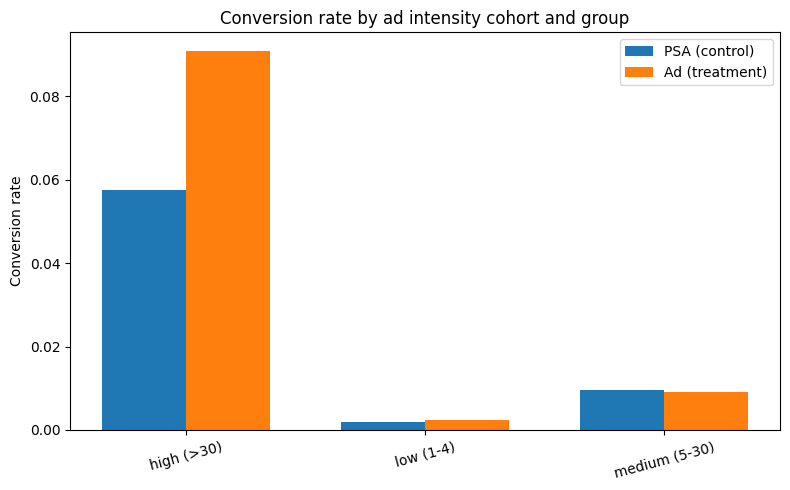

In [12]:
plot_int = intensity_group.pivot(index="ads_intensity_bucket", columns="test_group", values="conversion_rate")

x = np.arange(len(plot_int.index))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, plot_int["psa"], width, label="PSA (control)")
ax.bar(x + width/2, plot_int["ad"], width, label="Ad (treatment)")

ax.set_xticks(x)
ax.set_xticklabels(plot_int.index, rotation=15)
ax.set_ylabel("Conversion rate")
ax.set_title("Conversion rate by ad intensity cohort and group")
ax.legend()

plt.tight_layout()
plt.show()


### Step 4 – Logistic Regression (Optional but Powerful)

**Business question:**  
After accounting for how many ads users see and which day they see them, does the Ad still provide a meaningful lift over the PSA?

**What we do in this step:**
- Fit a **binary logistic regression**:

  \[
  \text{converted} ~ is\_ad + total\_ads + most\_ads\_day\_index
  \]

- Treat `is_ad` as the treatment indicator (1 = Ad, 0 = PSA).

**Why it matters:**
- Logistic regression estimates the **log-odds of conversion** while holding other factors constant.
- The coefficient on `is_ad` captures the **incremental effect of the Ad**, beyond what can be explained by volume and day-of-week.
- When we exponentiate that coefficient, we get an **odds ratio (OR)**:
  - OR > 1 → the Ad **increases** odds of conversion vs PSA.
  - OR < 1 → the Ad **reduces** odds of conversion vs PSA.

This gives a more **causally convincing story** than simple group averages and supports stronger business decisions around rollout and targeting.


In [13]:
import statsmodels.formula.api as smf
import numpy as np

# Make sure no missing values in fields used
logit_df = features.dropna(subset=["converted", "test_group", "total_ads", "most_ads_day_index"]).copy()

# Encode test_group as a binary indicator 'is_ad'
logit_df["is_ad"] = (logit_df["test_group"] == "ad").astype(int)

# Fit logistic regression
model = smf.logit("converted ~ is_ad + total_ads + most_ads_day_index", data=logit_df).fit()

print(model.summary())


Optimization terminated successfully.
         Current function value: 0.108779
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               588101
Model:                          Logit   Df Residuals:                   588097
Method:                           MLE   Df Model:                            3
Date:                Tue, 25 Nov 2025   Pseudo R-squ.:                 0.07642
Time:                        10:33:46   Log-Likelihood:                -63973.
converged:                       True   LL-Null:                       -69267.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.1723      0.054    -77.892      0.000      -4.277      -4.067
is_ad

### Logistic Regression: Adjusted Treatment Effect (is_ad, total_ads, day)

**Key findings (controlling for total_ads and day-of-week index):**

- **Ad vs PSA (is_ad)**
  - Coefficient: **+0.39**, p < 0.001  
  - Odds ratio ≈ **1.48** (95% CI ≈ 1.34–1.64)  
  - **Interpretation:** For two users with the same ad volume and same day-of-week, the user who sees the **Ad** has about **48% higher odds of converting** than a user who sees the **PSA**.
  - **Business impact:** This is strong evidence that the Ad is genuinely better than PSA, not just a side effect of showing more ads or hitting certain days.

- **Ad volume (total_ads)**
  - Coefficient: **+0.0101**, p < 0.001  
  - Odds ratio ≈ **1.01** per additional ad  
  - **Interpretation:** Each extra ad impression increases conversion odds by about **1%**, holding other factors constant. Over many impressions, this compounds, but the marginal gain per extra ad is small.
  - **Business impact:** Frequency helps, but returns are shallow. We should **optimize frequency caps** instead of blindly pushing more impressions, especially in cohorts where the Ad already performs strongly.

- **Day-of-week index (most_ads_day_index)**
  - Coefficient: **−0.0669**, p < 0.001  
  - Odds ratio ≈ **0.94** per step later in the week  
  - **Interpretation:** Moving one day later in the week (e.g., Monday → Tuesday, Tuesday → Wednesday) is associated with about a **6–7% drop in conversion odds**, all else equal.
  - **Business impact:** Earlier in the week is structurally stronger for conversion. Budget and high-intensity Ad delivery should be **front-loaded to early-week days** where users are more responsive.

---

### So What?

- The Ad’s lift is **real and robust** even after controlling for how many ads people see and which day they see them.  
- Conversion is **more sensitive to “who/when” (day and cohort) than just “how many ads”**, which matches your cohort analysis.
- Recommended moves:
  1. **Commit to the Ad creative as the default** over PSA for this campaign.
  2. **Prioritize early-week delivery** and cohorts already identified as high-lift (e.g., high-intensity users).
  3. **Use smarter frequency caps**: incremental value per extra impression is modest, so over-serving medium cohorts is likely wasted spend.


In [14]:
params = model.params
conf = model.conf_int()
conf.columns = ["ci_lower", "ci_upper"]

# Extract for is_ad
beta = params["is_ad"]
ci_low = conf.loc["is_ad", "ci_lower"]
ci_high = conf.loc["is_ad", "ci_upper"]

# Convert log-odds to odds ratio
or_est = np.exp(beta)
or_low = np.exp(ci_low)
or_high = np.exp(ci_high)

or_est, or_low, or_high


(np.float64(1.48022153035222),
 np.float64(1.3380886442396438),
 np.float64(1.6374518895669388))

### Interpreting the Logistic Regression Treatment Effect (Odds Ratio)

To move from log-odds (logistic regression coefficients) to a more interpretable
metric, we exponentiated the `is_ad` coefficient and its 95% confidence interval:

- **Estimated odds ratio (OR) for Ad vs PSA:** ~**1.48**
- **95% CI for OR:** [**1.34**, **1.64**]

**What this means:**

- After controlling for **how many ads** a user sees (`total_ads`) and **which day**
  they see them (`most_ads_day_index`), being in the **Ad group** increases the odds
  of conversion by about **48%** compared to the PSA group.
- The entire 95% confidence interval lies **above 1**, which indicates the Ad’s
  advantage over PSA is **statistically robust**, not just noise.

**Business impact:**

- The Ad creative is not only better on average, it remains **materially stronger**
  even when we adjust for volume and timing.
- This is strong evidence to **promote the Ad as the default treatment**, and then
  optimize **where and how often** we show it (e.g., high-intensity and early-week
  cohorts) rather than debating Ad vs PSA.
